# Projeto 3: GPU
### Filipe F. Borba  
### Insper
### Super Computação, Prof. Igor Montagner


## Introdução

O problema explorado nesse projeto é o algoritmo do Caixeiro Viajante. Este problema encontra-se na área de Otimização discreta, que estuda problemas de otimização baseados em uma sequência de escolhas e que a solução ótima só pode ser encontrada se enumerarmos todas as escolhas possíveis. Em outras palavras, só conseguimos achar a solução ótima se tivermos todas as soluções possíveis. Assim, não existem algoritmos mais eficientes de resolução, pois todos tem complexidade O(2^n) ou pior.

Ao realizar esse teste das sequências de escolhas em paralelo, podemos diminuir consideravelmente o consumo de tempo do programa, o que é bastante interessante para computacão paralela. Contudo, conseguimos potencializar ainda mais essa solução ao utilizar uma GPU que supera a CPU nesses casos, pois possui centenas de threads disponíveis para realizar os cálculos.

O problema do Caixeiro Viajante é o seguinte:

<img src="https://camo.githubusercontent.com/a4d91635c96d345fc31068a4420834d23654f82b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f312f31312f474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672f35313270782d474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672e706e67" alt="TSP" style="width: 300px;"/>

```Um vendedor possui uma lista de empresas que ele deverá visitar em um certo dia. Não existe uma ordem fixa: desde que todos sejam visitados seu objetivo do dia está cumprido. Interessado em passar o maior tempo possível nos clientes ele precisa encontrar a sequência de visitas que resulta no menor caminho.```

Para nosso projeto em específico, temos algumas simplificações:
- o nosso caixeiro usa Waze e já sabe qual é o caminho com a menor distância entre dois pontos;
- ele começa seu trajeto na empresa 0. Ou seja, basta ele encontrar um trajeto que passe por todas as outras e volte a empresa ```0```;
- ele não pode passar duas vezes na mesma empresa. Ou seja, a saída é uma permutação de ```0 ... (N-1)```



Finalmente, os objetivos deste projeto são

1. implementar uma versão GPU em C++ do caixeiro viajante a partir de uma versão sequencial em C++.
2. Estudar e implementar os seguintes métodos paralelos:
    * busca local paralela usando 2-opt

** Como descrito em https://github.com/Insper/supercomp/blob/master/projeto-02/enunciado.md

## Organização do Projeto

O projeto foi realizado utilizando a linguagem C++ e o compilador nvcc do CUDA na máquina p2.xlarge da AWS (que possui uma GPU NVIDIA Tesla K80). Temos, então, alguns arquivos diferentes.

* Arquivo random_sol.cu, que gera 10000 soluções aleatórias e retorna o melhor resultado entre elas.
* Arquivo 2opt_sol.cu, que gera 10000 soluções aleatórias, mas as otimiza utilizando a busca local 2-opt.

Além disso, o projeto possui um CMakeLists.txt que possibilita a compilação dos executáveis. São eles:
* random_sol (solução aleatória em GPU)
* 2opt_spl (solução aleatória em GPU com otimização 2-opt)
* time_random_sol (sem print de tempo - solução aleatória em GPU)
* time_2opt_spl (sem print de tempo - solução aleatória em GPU com otimização 2-opt)

Para compilar todos os executáveis, basta usar os seguintes comandos na pasta raíz do projeto:

```mkdir build; cd build; cmake ..; make ```

O comando ```make``` é responsável por compilar os executáveis.
Após isso, para iniciar cada executável, basta utilizar o comando 

```./nome_do_arquivo < ../tests/nome_da_entrada```

dentro da pasta ```build```.

## Comparação com CPU

O projeto em GPU tem diferenças bastante significativas em relação ao projeto em CPU. Podemos comparar com uma lista de prós em contras.

Projeto GPU:
Vantagens:
- Consegue lidar com entradas muito maiores (CPU travava com 15, GPU roda em alguns ms entrada de tamanho 32).
- Problemas intratáveis em paralelo acabam sendo tratáveis, pois temos tempos mais razoáveis de execução.

Desvantagens:
- Maior dificuldade de paralelizar o código (código CUDA mais difícil que OpenMP).
- Não devolve o custo mais otimizado nesse caso.

Podemos então concluir que a implementação em paralelo para problemas pequenos é bastante interessante, pois temos a solução ótima nesses casos. Contudo, para problemas maiores, a solução paralela demora muito mais, então a GPU acaba "brilhando" nesse caso. Apesar de não trazer a solução ótima, ela consegue computar o problema.

## Resultados

# Testes de Desempenho

Aqui estamos preocupados com a diferença de desempenho, então o tamanho das entradas é maior. O tempo foi medido a partir da biblioteca <cuda_runtime> e o nvprof do próprio CUDA. Testaremos então o tempo de uma execução e a saída para as duas soluções em GPU (aleatório e 2-opt). Para isso, existem alguns problemas já resolvidos que serão utilizados de exemplo aqui. São eles:
- berlin52.txt (N = 52)
- ch130.txt (N = 130)
- gil262.txt (N = 262)

OBS: outros executáveis foram criados para que a saída devolvesse o tempo, mas o código neles é igual.

In [1]:
key = "/home/filipefborba/Documents/Keys/IgorNvidia.pem"
host = "ec2-user@ec2-54-198-90-27.compute-1.amazonaws.com" # MUDAR O IP AQUI
working_directory = "/home/ec2-user/borba/supercomp/projeto-03/" # MUDAR A PASTA AQUI

In [2]:
%matplotlib inline
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [3]:
# Listar os executaveis
output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory+"build/", "&&", "ls"])
output = output.decode("utf-8").splitlines()
files = sorted([x for x in output if (x.endswith("sol") and not x.startswith("time"))])
files

['2opt_sol', 'random_sol']

In [4]:
# Pegar o nome das entradas menores
output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory, "&&", "ls"])
output = output.decode("utf-8").splitlines()
inputs = sorted([x for x in output if (x.endswith(".txt") and (x != "CMakeLists.txt"))])
inputs

['berlin52.txt', 'ch130.txt', 'gil262.txt']

In [5]:
# Converter us para ms
def fix_time(time):
    if (time.endswith("us")):
        return float(time[:-2])/1000
    elif (time.endswith("ms")):
        return float(time[:-2])
    elif (time.endswith("s")):
        return float(time[:-1])*1000
    else:
        print("time not us, ms or s")
        return 0

In [6]:
def get_name_and_time(output, name):
    if (name == "2opt_sol"):
        name = "opt_sol"
    for s in output:
        found_name = s.find(name)
        if found_name != -1:
            result = s[found_name:found_name+len(name)]
            found_time = re.search('%(.*)s ', s)
            if (found_time == None):
                pass
            else:
                print(found_time.group(1).split()[0], result)
                return found_time.group(1).split()[0], result

In [13]:
# Tempos de alocacao e copia de memoria, alem de kernel.
def run_basic_test(file, input_file):
    with open('./tests/' + input_file, 'rb', 0) as f:
        output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory, "&&",
                                     f"./{file}"], stdin=f, stderr=subprocess.STDOUT)
        output = output.decode("utf-8").splitlines()
    
    print(f"--{file}------{input_file}--")
    print(output[2])
    print(output[3])

In [8]:
# Tempos de alocacao e copia de memoria, alem de kernel.
def run_nvprof_test(file, input_file):
    with open('./tests/' + input_file, 'rb', 0) as f:
        output = subprocess.check_output(["ssh", "-i", key, host, "cd", working_directory, "&&",
                                     "nvprof", f"./{file}"], stdin=f, stderr=subprocess.STDOUT)
        output = output.decode("utf-8").splitlines()
    
    print(f"--{file}------{input_file}--")
    kernel_time, kernel_name = get_name_and_time(output, str(file))
    htod_time, htod_name = get_name_and_time(output, "[CUDA memcpy HtoD]")
    dtoh_time, dtoh_name = get_name_and_time(output, "[CUDA memcpy DtoH]")
    malloc_time, malloc_name = get_name_and_time(output, "cudaMalloc")
    kernel_time = fix_time(kernel_time)
    htod_time = fix_time(htod_time)
    dtoh_time = fix_time(dtoh_time)
    malloc_time = fix_time(malloc_time)
    return [file, input_file,
        kernel_time, kernel_name,
        htod_time, htod_name,
        dtoh_time, dtoh_name,
        malloc_time, malloc_name
           ]

In [14]:
# Vamos rodar um teste básico para ver a qualidade da solucao. O ch130.txt é suficiente.
for f in files:
    run_basic_test(f, "ch130.txt")

--2opt_sol------ch130.txt--
14252.90850 0
0 120 66 5 101 9 12 95 8 81 88 30 33 63 60 108 75 44 10 4 15 70 129 1 24 47 25 96 6 123 128 38 79 117 68 85 87 69 106 126 62 118 76 112 35 83 31 97 67 109 93 18 26 84 65 124 89 77 22 107 7 17 13 121 54 59 50 119 41 43 92 116 114 27 111 72 55 110 122 100 56 51 74 73 91 16 53 104 61 127 103 42 28 11 86 64 98 90 71 19 58 29 82 34 78 94 102 80 37 105 57 48 52 3 99 14 23 115 45 2 113 125 32 21 46 39 36 20 49 40 
--random_sol------ch130.txt--
37835.12676 0
0 69 18 97 101 77 57 98 87 82 19 51 6 23 27 104 70 33 53 55 81 124 36 30 17 123 103 42 83 31 47 24 66 52 119 127 62 126 94 37 38 88 50 109 67 80 64 35 49 95 121 5 107 79 3 25 85 93 2 7 65 61 96 56 8 118 72 71 128 102 76 110 68 44 59 92 9 13 12 90 122 78 4 39 84 74 22 73 116 60 100 46 14 16 29 115 48 10 111 91 41 112 125 63 26 58 21 45 99 113 86 120 20 105 11 54 1 32 108 15 114 117 28 43 129 75 34 40 89 106 


In [10]:
data = []
for i in inputs:
    for f in files:
        data.append(run_nvprof_test(f, i))

--2opt_sol------berlin52.txt--
547.47ms opt_sol
4.2560us [CUDA memcpy HtoD]
115.87us [CUDA memcpy DtoH]
127.71ms cudaMalloc
--random_sol------berlin52.txt--
37.293ms random_sol
3.9670us [CUDA memcpy HtoD]
115.29us [CUDA memcpy DtoH]
125.39ms cudaMalloc
--2opt_sol------ch130.txt--
8.79075s opt_sol
4.1600us [CUDA memcpy HtoD]
277.60us [CUDA memcpy DtoH]
126.40ms cudaMalloc
--random_sol------ch130.txt--
85.575ms random_sol
4.1940us [CUDA memcpy HtoD]
278.97us [CUDA memcpy DtoH]
126.35ms cudaMalloc
--2opt_sol------gil262.txt--
76.0782s opt_sol
4.5120us [CUDA memcpy HtoD]
557.05us [CUDA memcpy DtoH]
124.59ms cudaMalloc
--random_sol------gil262.txt--
191.19ms random_sol
4.5120us [CUDA memcpy HtoD]
558.94us [CUDA memcpy DtoH]
134.11ms cudaMalloc


In [11]:
df = pd.DataFrame(data, dtype=np.float64)
df

# Coluna 0: Executável
# Coluna 1: Entrada
# Coluna 2: Tempo de execução Kernel
# Coluna 3: Nome kernel
# Coluna 4: Tempo de execução Memcpy
# Coluna 5: Nome memcpy HtoD
# Coluna 6: Tempo de execução Memcpy
# Coluna 7: Nome memcpy DtoH
# Coluna 8: Tempo de execução Malloc

,0,1,2,3,4,5,6,7,8,9
0,2opt_sol,berlin52.txt,547.470,opt_sol,0.004256,[CUDA memcpy HtoD],0.11587,[CUDA memcpy DtoH],127.71,cudaMalloc
1,random_sol,berlin52.txt,37.293,random_sol,0.003967,[CUDA memcpy HtoD],0.11529,[CUDA memcpy DtoH],125.39,cudaMalloc
2,2opt_sol,ch130.txt,8790.750,opt_sol,0.004160,[CUDA memcpy HtoD],0.27760,[CUDA memcpy DtoH],126.40,cudaMalloc
3,random_sol,ch130.txt,85.575,random_sol,0.004194,[CUDA memcpy HtoD],0.27897,[CUDA memcpy DtoH],126.35,cudaMalloc
4,2opt_sol,gil262.txt,76078.200,opt_sol,0.004512,[CUDA memcpy HtoD],0.55705,[CUDA memcpy DtoH],124.59,cudaMalloc
5,random_sol,gil262.txt,191.190,random_sol,0.004512,[CUDA memcpy HtoD],0.55894,[CUDA memcpy DtoH],134.11,cudaMalloc


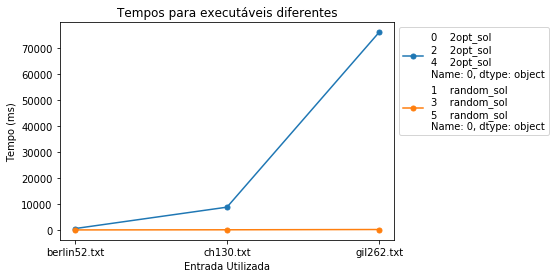

In [12]:
groups = df.groupby(0)

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group[1], group[2], marker='o', linestyle='-', ms=5, label=group[0])
plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('Entrada Utilizada')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Como podemos verificar no gráfico acima, o algoritmo 2opt_sol acaba sendo MUITO mais lento que o random_sol. Isso acontece porque o 2opt realiza 2 fors que permutam a solução aleatória com o objetivo de encontrar um custo melhor. Além disso, para cada permutação, ele recalcula o custo total, sendo, novamente, bem ineficiente em termos de operações.  
Contudo, como pudemos verificar nos testes básicos, o 2opt acaba encontrando caminhos com custo bem menores, o que acaba sendo muito interessante, visto que sua implementação está totalmente ingênua.

Ainda, verificando o dataframe, podemos verificar que o tempo de alocação de memória e cópia acaba sendo quase insignificante perto do tempo de processamento do kernel das funções. Esse efeito acaba crescendo muito quanto maior as entradas: o tempo de "preparação" é mínimo e de processamento é máximo.

Para melhorar o programa, seria necessário otimizar a memória e balancear melhor as cargas das threads. Ainda, seria interessante a utilização do Branch and Bound nesse caso, mas a implementação não é tão trivial. 